# ***DATA LOADING AND PREPROCESSING***

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib


def load_and_preprocess_data(excel_path):

    print("Loading data from:", excel_path)
    if excel_path.endswith('.xlsx'):
        df = pd.read_excel(excel_path)
    else:

        df = pd.read_csv(excel_path, sep='\t', engine='python')

    print(f"Total records loaded: {len(df)}")

    if 'CLASS' in df.columns:
        print("Raw CLASS distribution:\n", df['CLASS'].value_counts())
    else:
        print("WARNING: 'CLASS' column not found in DataFrame.")

    return df


def prepare_labels_bohrbug_mandelbug(df):

    print("\nPreparing Bohrbug vs. Mandelbug labels")

    label_mapping = {
        'BOH': 'Bohrbug',
        'NAM': 'Mandelbug',
        'ARB': 'Mandelbug',
    }


    df['bug_type'] = df['CLASS'].map(label_mapping)


    before = len(df)
    df = df.dropna(subset=['bug_type'])
    after = len(df)
    print(f"  Dropped {before - after} rows.")
    print("Label distribution (post‐mapping):\n", df['bug_type'].value_counts())

    return df.reset_index(drop=True)


def create_expanded_text_and_meta(df, append_meta_to_text=True):

    print("\nBuilding expanded text features + metadata columns")
    text_features = []
    product_col   = []
    component_col = []
    severity_col  = []
    priority_col  = []
    hardware_col  = []

    for idx, row in df.iterrows():

        parts = []
        if pd.notna(row.get('summary', '')):
            s = str(row['summary']).strip()
            if s:
                parts.append(s)

        if pd.notna(row.get('description', '')):
            d = str(row['description']).strip()
            if d:
                parts.append(d)

        combined_text = " ".join(parts).strip()
        if not combined_text:
            combined_text = "No description available"


        prod      = row.get('product',   '')
        comp      = row.get('component', '')
        sev       = row.get('severity',  '')
        prio      = row.get('priority',  '')
        hard      = row.get('hardware',  '')


        prod      = str(prod).strip() if pd.notna(prod)   else ''
        comp      = str(comp).strip() if pd.notna(comp)   else ''
        sev       = str(sev).strip() if pd.notna(sev)     else ''
        prio      = str(prio).strip() if pd.notna(prio)   else ''
        hard      = str(hard).strip() if pd.notna(hard)   else ''


        if append_meta_to_text:
            meta_tokens = []
            if prod:
                meta_tokens.append(f"[PRODUCT: {prod}]")
            if comp:
                meta_tokens.append(f"[COMPONENT: {comp}]")
            if sev:
                meta_tokens.append(f"[SEVERITY: {sev}]")
            if prio:
                meta_tokens.append(f"[PRIORITY: {prio}]")
            if hard:
                meta_tokens.append(f"[HARDWARE: {hard}]")

            if meta_tokens:
                combined_text = combined_text + " " + " ".join(meta_tokens)


        text_features.append(combined_text)
        product_col.append(prod)
        component_col.append(comp)
        severity_col.append(sev)
        priority_col.append(prio)
        hardware_col.append(hard)


    lengths = [len(t) for t in text_features]
    print("  Text‐feature stats:")
    print(f"    Total samples: {len(text_features)}")
    print(f"    Average length: {np.mean(lengths):.1f} chars")
    print(f"    Min length: {min(lengths)}")
    print(f"    Max length: {max(lengths)}")

    return (
        text_features,
        product_col,
        component_col,
        severity_col,
        priority_col,
        hardware_col
    )


def create_training_data(
    df,
    text_features,
    product_col,
    component_col,
    severity_col,
    priority_col,
    hardware_col,
    output_dir,
    test_size=0.2,
    random_state=42
):

    os.makedirs(output_dir, exist_ok=True)


    le = LabelEncoder()
    df['encoded_label'] = le.fit_transform(df['bug_type'])
    print("\nClasses after LabelEncoder:", dict(zip(le.classes_, le.transform(le.classes_))))


    expanded_df = pd.DataFrame({
        'text'      : text_features,
        'product'   : product_col,
        'component' : component_col,
        'severity'  : severity_col,
        'priority'  : priority_col,
        'hardware'  : hardware_col,
        'label'     : df['encoded_label'],
        'label_name': df['bug_type']
    })


    X = expanded_df.drop(columns=['label', 'label_name'])
    y = expanded_df['label']

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )


    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=random_state,
        stratify=y_temp
    )


    train_df = X_train.copy()
    train_df['label'] = y_train.values
    train_df['label_name'] = le.inverse_transform(y_train.values)

    val_df = X_val.copy()
    val_df['label'] = y_val.values
    val_df['label_name'] = le.inverse_transform(y_val.values)

    test_df = X_test.copy()
    test_df['label'] = y_test.values
    test_df['label_name'] = le.inverse_transform(y_test.values)


    train_csv = os.path.join(output_dir, 'train_data_expanded.csv')
    val_csv   = os.path.join(output_dir, 'val_data_expanded.csv')
    test_csv  = os.path.join(output_dir, 'test_data_expanded.csv')

    train_df.to_csv(train_csv, index=False)
    val_df.to_csv(val_csv,     index=False)
    test_df.to_csv(test_csv,   index=False)


    label_encoder_path = os.path.join(output_dir, 'label_encoder.pkl')
    joblib.dump(le, label_encoder_path)

    print("\n=== Data Splits Created ===")
    print(f"  Train:      {len(train_df)} samples  (distribution = {train_df['label_name'].value_counts().to_dict()})")
    print(f"  Validation: {len(val_df)} samples  (distribution = {val_df['label_name'].value_counts().to_dict()})")
    print(f"  Test:       {len(test_df)} samples  (distribution = {test_df['label_name'].value_counts().to_dict()})")
    print("\nFiles saved to", output_dir)
    print(f"  • {os.path.basename(train_csv)}, {os.path.basename(val_csv)}, {os.path.basename(test_csv)}")
    print(f"  • {os.path.basename(label_encoder_path)}")

    return train_df, val_df, test_df, le


def save_processed_reports_by_type(df, text_features, output_dir):

    os.makedirs(output_dir, exist_ok=True)
    boh_list  = []
    man_list  = []

    for idx, bug_type in enumerate(df['bug_type']):
        bid = df.iloc[idx].get('id', f'bug_{idx}')
        txt = text_features[idx]
        snippet = (
            f"Bug ID: {bid}\n"
            f"Type: {bug_type}\n"
            f"Content: {txt}\n"
            + "="*50 + "\n\n"
        )
        if bug_type == 'Bohrbug':
            boh_list.append(snippet)
        else:
            man_list.append(snippet)

    with open(os.path.join(output_dir, "Bohrbug_reports.txt"), "w", encoding="utf-8") as fboh:
        fboh.writelines(boh_list)
    with open(os.path.join(output_dir, "Mandelbug_reports.txt"), "w", encoding="utf-8") as fman:
        fman.writelines(man_list)

    print(f"\nSaved {len(boh_list)} Bohrbug reports and {len(man_list)} Mandelbug reports to {output_dir}")


def main():


    excel_path = "/content/drive/MyDrive/linux_data1.xlsx"
    output_dir = "/content/sample_data/bohrbug_mandelbug_expanded"

    print("=== Expanded Text + Metadata Preprocessing ===")
    print("Using fields: summary + description [+ optional meta tokens], and raw columns: product, component, severity, priority, hardware")
    print("Mapping CLASS → {Bohrbug, Mandelbug} only.\n")


    df = load_and_preprocess_data(excel_path)


    df_clean = prepare_labels_bohrbug_mandelbug(df)
    if df_clean.empty:
        print("ERROR: No valid rows after label mapping. Exiting.")
        return


    (text_features,
     product_col,
     component_col,
     severity_col,
     priority_col,
     hardware_col) = create_expanded_text_and_meta(df_clean, append_meta_to_text=True)


    save_processed_reports_by_type(df_clean, text_features, output_dir)


    train_df, val_df, test_df, label_encoder = create_training_data(
        df_clean,
        text_features,
        product_col,
        component_col,
        severity_col,
        priority_col,
        hardware_col,
        output_dir
    )

    print("\n=== Preprocessing Complete! ===")
    print("Expanded CSVs are ready for your fine‐tuning (BERT/SBERT) model.")
    print(f"→ Train: {os.path.join(output_dir, 'train_data_expanded.csv')}")
    print(f"→ Val:   {os.path.join(output_dir, 'val_data_expanded.csv')}")
    print(f"→ Test:  {os.path.join(output_dir, 'test_data_expanded.csv')}")
    print(f"→ Label Encoder: {os.path.join(output_dir, 'label_encoder.pkl')}")


if __name__ == "__main__":
    main()




=== Expanded Text + Metadata Preprocessing ===
Using fields: summary + description [+ optional meta tokens], and raw columns: product, component, severity, priority, hardware
Mapping CLASS → {Bohrbug, Mandelbug} only.

Loading data from: /content/drive/MyDrive/linux_data1.xlsx
Total records loaded: 4378
Raw CLASS distribution:
 CLASS
BOH    2444
NAM    1386
UNK     343
ARB     205
Name: count, dtype: int64

Preparing Bohrbug vs. Mandelbug labels
  Dropped 343 rows.
Label distribution (post‐mapping):
 bug_type
Bohrbug      2444
Mandelbug    1591
Name: count, dtype: int64

Building expanded text features + metadata columns
  Text‐feature stats:
    Total samples: 4035
    Average length: 2264.2 chars
    Min length: 129
    Max length: 32947

Saved 2444 Bohrbug reports and 1591 Mandelbug reports to /content/sample_data/bohrbug_mandelbug_expanded

Classes after LabelEncoder: {'Bohrbug': np.int64(0), 'Mandelbug': np.int64(1)}

=== Data Splits Created ===
  Train:      3228 samples  (distri

# ***TRANSFORM AND GROUP BUG REPORT FEATURES***

In [2]:

import pandas as pd
import os

DATA_DIR        = "/content/sample_data/bohrbug_mandelbug_expanded"
TRAIN_EXP_CSV   = "train_data_expanded.csv"
VAL_EXP_CSV     = "val_data_expanded.csv"
TEST_EXP_CSV    = "test_data_expanded.csv"

TRAIN_GROUPED_CSV = "train_data_grouped.csv"
VAL_GROUPED_CSV   = "val_data_grouped.csv"
TEST_GROUPED_CSV  = "test_data_grouped.csv"

TOP_K_COMPONENTS = 20


def group_component_series(series: pd.Series, top_k: int) -> pd.Series:

    counts = series.value_counts()
    top_list = counts.nlargest(top_k).index.tolist()

    def mapper(val):
        if pd.isna(val) or str(val).strip().lower() in ["", "nan", "none"]:
            return "Other"
        return val if val in top_list else "Other"

    return series.apply(mapper)


def group_priority_series(series: pd.Series) -> pd.Series:

    def mapper(val):
        if pd.isna(val) or str(val).strip().lower() in ["", "nan", "none"]:
            return "Other"
        v = str(val).strip()
        if v == "P1":
            return "P1"
        if v == "P2":
            return "P2"
        return "Other"

    return series.apply(mapper)


def group_hardware_series(series: pd.Series) -> pd.Series:

    def mapper(val):
        if pd.isna(val) or str(val).strip().lower() in ["", "nan", "none"]:
            return "Other"
        text = str(val).strip()
        if any(tok in text for tok in ["All Linux", "i386 Linux", "x86-64 Linux"]):
            return "x86"
        return "Other"

    return series.apply(mapper)


def collapse_severity_series(series: pd.Series) -> pd.Series:

    def mapper(val):
        if pd.isna(val) or str(val).strip().lower() in ["", "nan", "none"]:
            return "normal"
        v = str(val).strip().lower()
        if v == "enhancement":
            return "normal"
        return v
    return series.apply(mapper)



def preprocess_and_group(input_csv: str, output_csv: str, top_k_components: int):

    print(f"\nLoading expanded CSV: {input_csv}")
    df = pd.read_csv(input_csv)

    print(f"  Original shape: {df.shape}")
    required_cols = {'text','product','component','severity','priority','hardware','label','label_name'}
    if not required_cols.issubset(df.columns):
        missing = required_cols - set(df.columns)
        raise RuntimeError(f"Missing columns in {input_csv}: {missing}")

    df['text'] = df['text'].fillna("[EMPTY_NAN]").astype(str).str.strip()
    empty_texts = (df['text'] == "") | (df['text'].str.lower() == "nan")
    df.loc[empty_texts, 'text'] = "[EMPTY_NAN]"


    df['product'] = df['product'].fillna("UnknownProduct").astype(str).str.strip()
    df.loc[df['product'].str.lower().isin(["", "nan", "none"]), 'product'] = "UnknownProduct"

    df['component'] = df['component'].fillna("Other").astype(str).str.strip()
    df.loc[df['component'].str.lower().isin(["", "nan", "none"]), 'component'] = "Other"
    df['component_grouped'] = group_component_series(df['component'], top_k_components)

    df['severity'] = collapse_severity_series(df['severity'].fillna("normal"))

    df['priority'] = df['priority'].fillna("Other")
    df.loc[df['priority'].str.lower().isin(["", "nan", "none"]), 'priority'] = "Other"
    df['priority_grouped'] = group_priority_series(df['priority'])

    df['hardware'] = df['hardware'].fillna("Other")
    df.loc[df['hardware'].str.lower().isin(["", "nan", "none"]), 'hardware'] = "Other"
    df['hardware_grouped'] = group_hardware_series(df['hardware'])


    df = df.rename(columns={
        'component': 'component_raw',
        'priority':  'priority_raw',
        'hardware':  'hardware_raw'
    })


    print("  Unique counts after grouping:")
    print(f"    product unique         : {df['product'].nunique()}")
    print(f"    component_grouped unique: {df['component_grouped'].nunique()}")
    print(f"    severity unique        : {df['severity'].nunique()}")
    print(f"    priority_grouped unique: {df['priority_grouped'].nunique()}")
    print(f"    hardware_grouped unique: {df['hardware_grouped'].nunique()}")
    print(f"  Label distribution (0=Bohrbug,1=Mandelbug):")
    print(df['label_name'].value_counts())

    print(f"  Saving grouped CSV: {output_csv} (shape = {df.shape})")
    df.to_csv(output_csv, index=False)
    print(f"  ✔ Done saving {output_csv}")


if __name__ == "__main__":
    os.makedirs(DATA_DIR, exist_ok=True)

    train_in  = os.path.join(DATA_DIR, TRAIN_EXP_CSV)
    val_in    = os.path.join(DATA_DIR, VAL_EXP_CSV)
    test_in   = os.path.join(DATA_DIR, TEST_EXP_CSV)

    train_out = os.path.join(DATA_DIR, TRAIN_GROUPED_CSV)
    val_out   = os.path.join(DATA_DIR, VAL_GROUPED_CSV)
    test_out  = os.path.join(DATA_DIR, TEST_GROUPED_CSV)

    preprocess_and_group(train_in, train_out, TOP_K_COMPONENTS)

    preprocess_and_group(val_in, val_out, TOP_K_COMPONENTS)

    preprocess_and_group(test_in, test_out, TOP_K_COMPONENTS)

    print("\nAll CSVs grouped and saved successfully. You can now use:")
    print(f"  • Train grouped: {train_out}")
    print(f"  • Val grouped:   {val_out}")
    print(f"  • Test grouped:  {test_out}")
    print("\nThese CSVs contain additional columns:")
    print("  component_grouped, priority_grouped, hardware_grouped")
    print("as well as the original raw columns renamed:")
    print("  component_raw, priority_raw, hardware_raw")
    print("\nUse these grouped files in your Dataset ")




Loading expanded CSV: /content/sample_data/bohrbug_mandelbug_expanded/train_data_expanded.csv
  Original shape: (3228, 8)
  Unique counts after grouping:
    product unique         : 16
    component_grouped unique: 20
    severity unique        : 4
    priority_grouped unique: 3
    hardware_grouped unique: 2
  Label distribution (0=Bohrbug,1=Mandelbug):
label_name
Bohrbug      1955
Mandelbug    1273
Name: count, dtype: int64
  Saving grouped CSV: /content/sample_data/bohrbug_mandelbug_expanded/train_data_grouped.csv (shape = (3228, 11))
  ✔ Done saving /content/sample_data/bohrbug_mandelbug_expanded/train_data_grouped.csv

Loading expanded CSV: /content/sample_data/bohrbug_mandelbug_expanded/val_data_expanded.csv
  Original shape: (403, 8)
  Unique counts after grouping:
    product unique         : 15
    component_grouped unique: 20
    severity unique        : 4
    priority_grouped unique: 2
    hardware_grouped unique: 2
  Label distribution (0=Bohrbug,1=Mandelbug):
label_name


# ***FINAL MODEL TRAINING AND EVAlUATION***

Bohr/Mandelbug Classification with Text + Metadata
---------------------------------------------------------------------------
DATA_DIR                 : /content/sample_data/bohrbug_mandelbug_expanded
MODEL_NAME_OR_PATH       : /content/drive/MyDrive/sem_model_4
TRAIN_FILE               : train_data_grouped.csv
VAL_FILE                 : val_data_grouped.csv
TEST_FILE                : test_data_grouped.csv
LABEL_ENCODER_FILE       : label_encoder.pkl
MAX_LENGTH               : 256
BATCH_SIZE               : 8
LEARNING_RATE            : 2e-05
WEIGHT_DECAY             : 0.01
EPOCHS                   : 7
DEVICE                   : cuda
PATIENCE                 : 3
SAVE_MODEL               : True
GRADIENT_ACCUMULATION_STEPS: 2
OUTPUT_MODEL_DIR         : /content/bohr_mandelbug_classifier_with_meta
USE_WEIGHTED_SAMPLING    : True
TRAIN_ON_COMBINED_DATA   : True
NUM_WORKERS              : 0
MAX_GRAD_NORM            : 1.0
WARMUP_RATIO             : 0.1
---------------------------------------

Epoch 1: Train Loss: 1.4909, Val Loss: 0.5686
           Train Acc: 0.5828, Val Acc: 0.6923, Val F1 (W): 0.6912
  Bohrbug Val F1: 0.7490
  Mandelbug Val F1: 0.6026
New best Val F1 (W): 0.6912. Model saved.


Epoch 2: Train Loss: 0.5522, Val Loss: 0.4701
           Train Acc: 0.7276, Val Acc: 0.7891, Val F1 (W): 0.7896
  Bohrbug Val F1: 0.8240
  Mandelbug Val F1: 0.7368
New best Val F1 (W): 0.7896. Model saved.


Epoch 3: Train Loss: 0.4758, Val Loss: 0.4113
           Train Acc: 0.7791, Val Acc: 0.8189, Val F1 (W): 0.8205
  Bohrbug Val F1: 0.8430
  Mandelbug Val F1: 0.7859
New best Val F1 (W): 0.8205. Model saved.


Epoch 4: Train Loss: 0.3991, Val Loss: 0.3217
           Train Acc: 0.8218, Val Acc: 0.8536, Val F1 (W): 0.8545
  Bohrbug Val F1: 0.8758
  Mandelbug Val F1: 0.8218
New best Val F1 (W): 0.8545. Model saved.


Epoch 5: Train Loss: 0.3777, Val Loss: 0.2645
           Train Acc: 0.8375, Val Acc: 0.8883, Val F1 (W): 0.8888
  Bohrbug Val F1: 0.9061
  Mandelbug Val F1: 0.8624
New best Val F1 (W): 0.8888. Model saved.


Epoch 6: Train Loss: 0.3186, Val Loss: 0.2373
           Train Acc: 0.8615, Val Acc: 0.9032, Val F1 (W): 0.9040
  Bohrbug Val F1: 0.9168
  Mandelbug Val F1: 0.8843
New best Val F1 (W): 0.9040. Model saved.


Epoch 7: Train Loss: 0.3171, Val Loss: 0.2160
           Train Acc: 0.8681, Val Acc: 0.9181, Val F1 (W): 0.9185
  Bohrbug Val F1: 0.9308
  Mandelbug Val F1: 0.8997
New best Val F1 (W): 0.9185. Model saved.
Loaded best model weights from 'best_model_temp.pth'
Training history plot saved to /content/training_history_with_meta.png


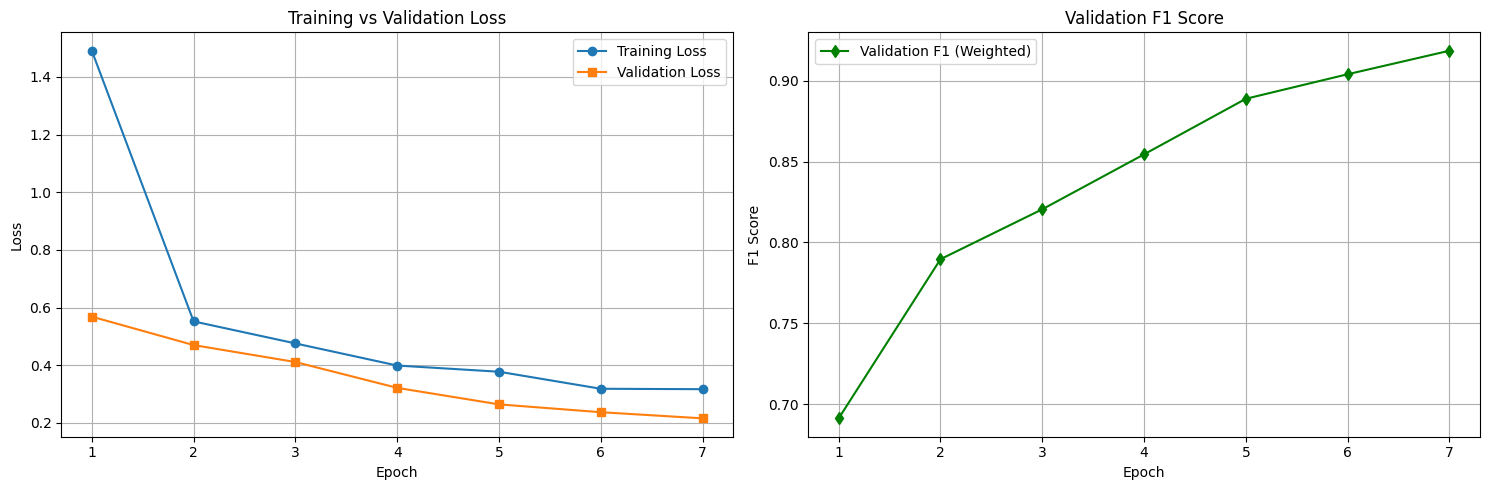


Final Model Evaluation on Test Set


Evaluating Final Model: 100%|██████████| 26/26 [00:01<00:00, 15.25it/s]



Final Model Evaluation Classification Report:
              precision    recall  f1-score   support

     Bohrbug       0.77      0.81      0.79       245
   Mandelbug       0.69      0.64      0.66       159

    accuracy                           0.74       404
   macro avg       0.73      0.72      0.73       404
weighted avg       0.74      0.74      0.74       404

Saved fine-tuned model and tokenizer to /content/bohr_mandelbug_classifier_with_meta

Final Results
Best Validation F1 (Weighted): 0.9185
Test Accuracy: 0.7426
Test Precision (W): 0.7400
Test Recall (W): 0.7426
Test F1 (Weighted): 0.7406

Final GPU Memory Status:
GPU Available: Tesla T4
GPU Memory Total: 14.7 GB
Currently Allocated: 0.0 GB
Currently Cached (Reserved): 0.5 GB


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import joblib
from collections import Counter
import os
import gc
import random
from torch.nn.utils import clip_grad_norm_
import traceback

warnings.filterwarnings('ignore')

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

def check_gpu_info():
    if torch.cuda.is_available():
        print(f"GPU Available: {torch.cuda.get_device_name(0)}")
        try:
            total_memory = torch.cuda.get_device_properties(0).total_memory
            allocated_memory = torch.cuda.memory_allocated(0)
            reserved_memory = torch.cuda.memory_reserved(0)
            print(f"GPU Memory Total: {total_memory / 1024**3:.1f} GB")
            print(f"Currently Allocated: {allocated_memory / 1024**3:.1f} GB")
            print(f"Currently Cached (Reserved): {reserved_memory / 1024**3:.1f} GB")
        except Exception as e:
            print(f"Could not get detailed GPU memory info: {e}")
    else:
        print("GPU not available, using CPU")

CONFIG = {
    'DATA_DIR': '/content/sample_data/bohrbug_mandelbug_expanded',
    'MODEL_NAME_OR_PATH': '/content/drive/MyDrive/sem_model_4',
    'TRAIN_FILE': 'train_data_grouped.csv',
    'VAL_FILE': 'val_data_grouped.csv',
    'TEST_FILE': 'test_data_grouped.csv',
    'LABEL_ENCODER_FILE': 'label_encoder.pkl',
    'MAX_LENGTH': 256,
    'BATCH_SIZE': 8,
    'LEARNING_RATE': 2e-5,
    'WEIGHT_DECAY': 0.01,
    'EPOCHS': 7,
    'DEVICE': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'PATIENCE': 3,
    'SAVE_MODEL': True,
    'GRADIENT_ACCUMULATION_STEPS': 2,
    'OUTPUT_MODEL_DIR': '/content/bohr_mandelbug_classifier_with_meta',
    'USE_WEIGHTED_SAMPLING': True,
    'TRAIN_ON_COMBINED_DATA': True,
    'NUM_WORKERS': 0,
    'MAX_GRAD_NORM': 1.0,
    'WARMUP_RATIO': 0.1,
}

class SimpleTextWithMetaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_len: int):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        text = str(row['text']).strip()
        if not text:
            text = "[EMPTY]"

        meta_tokens = []
        for col in ['product', 'component_grouped', 'severity', 'priority_grouped', 'hardware_grouped']:
            val = row.get(col, "")
            if isinstance(val, float) and np.isnan(val):
                continue
            val_str = str(val).strip()
            if val_str and val_str.lower() not in ['nan', 'none']:
                token = f"[{col.replace('_grouped','').upper()}: {val_str}]"
                meta_tokens.append(token)

        if meta_tokens:
            full_text = text + " " + " ".join(meta_tokens)
        else:
            full_text = text

        encoding = self.tokenizer.encode_plus(
            full_text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        label = torch.tensor(row['label'], dtype=torch.long)
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

def load_bohr_mandelbug_data():
    print("Loading Bohr/Mandelbug data...")
    data_dir = CONFIG['DATA_DIR']
    try:
        if not os.path.exists(data_dir):
            raise FileNotFoundError(f"Data directory not found: {data_dir}")

        train_csv = os.path.join(data_dir, CONFIG['TRAIN_FILE'])
        val_csv = os.path.join(data_dir, CONFIG['VAL_FILE'])
        test_csv = os.path.join(data_dir, CONFIG['TEST_FILE'])

        if not os.path.exists(train_csv):
            raise FileNotFoundError(f"Train file not found: {train_csv}")
        if not os.path.exists(val_csv):
            raise FileNotFoundError(f"Val file not found: {val_csv}")
        if not os.path.exists(test_csv):
            raise FileNotFoundError(f"Test file not found: {test_csv}")

        train_df = pd.read_csv(train_csv)
        val_df = pd.read_csv(val_csv)
        test_df = pd.read_csv(test_csv)

        le_path = os.path.join(data_dir, CONFIG['LABEL_ENCODER_FILE'])
        if os.path.exists(le_path):
            try:
                label_encoder = joblib.load(le_path)
                print(f"Loaded existing label encoder from {le_path}")
            except Exception as e:
                print(f"Failed to load label encoder at {le_path}: {e}")
                print("Creating a new LabelEncoder from train_df['label_name'].")
                label_encoder = None
        else:
            print(f"label_encoder.pkl not found at {le_path}. Creating a new one.")
            label_encoder = None

        for name, df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
            print(f"{name} - rows before cleaning: {len(df)}; missing text: {df['text'].isna().sum()}")
            df['text'] = df['text'].fillna("[EMPTY_NAN]").astype(str).str.strip()
            df.dropna(subset=['label'], inplace=True)
            print(f"{name} - rows after cleaning: {len(df)}")

        if label_encoder is None:
            from sklearn.preprocessing import LabelEncoder
            label_encoder = LabelEncoder()
            unique_labels = train_df['label_name'].astype(str).unique().tolist()
            label_encoder.fit(unique_labels)
            try:
                joblib.dump(label_encoder, le_path)
                print(f"Saved new label encoder to {le_path}")
            except Exception as e:
                print(f"Failed to save new label encoder to {le_path}: {e}")

        print(f"\nData Loaded - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
        print("Train label distribution (counts):")
        print(train_df['label_name'].value_counts())
        if train_df['label_name'].nunique() > 1:
            ratio = train_df['label_name'].value_counts().min() / train_df['label_name'].value_counts().max()
            print(f"Class balance ratio (min/max) = {ratio:.3f}")

        return train_df, val_df, test_df, label_encoder

    except Exception as e:
        print(f"Error loading data: {e}")
        raise

def train_fold_with_accumulation(model, train_loader, val_loader, optimizer, scheduler, epochs, patience, label_encoder_obj):
    best_val_f1 = 0.0
    patience_counter = 0
    target_names = list(label_encoder_obj.classes_)
    train_losses, val_losses, val_f1_scores = [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss_epoch = 0.0
        train_correct = 0
        total_train = 0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} Training', leave=False)
        for batch_idx, batch in enumerate(progress_bar):
            if batch_idx % CONFIG['GRADIENT_ACCUMULATION_STEPS'] == 0:
                optimizer.zero_grad(set_to_none=True if CONFIG['DEVICE'].type == 'cuda' else False)

            input_ids = batch['input_ids'].to(CONFIG['DEVICE'])
            attention_mask = batch['attention_mask'].to(CONFIG['DEVICE'])
            labels = batch['labels'].to(CONFIG['DEVICE'])

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss = loss / CONFIG['GRADIENT_ACCUMULATION_STEPS']
            loss.backward()

            train_loss_epoch += loss.item() * CONFIG['GRADIENT_ACCUMULATION_STEPS']
            preds = outputs.logits.argmax(dim=1)
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

            if (batch_idx + 1) % CONFIG['GRADIENT_ACCUMULATION_STEPS'] == 0:
                clip_grad_norm_(model.parameters(), CONFIG['MAX_GRAD_NORM'])
                optimizer.step()
                if scheduler:
                    scheduler.step()

            current_loss = loss.item() * CONFIG['GRADIENT_ACCUMULATION_STEPS']
            progress_bar.set_postfix({'loss': f'{current_loss:.4f}'})

            if batch_idx > 0 and batch_idx % 100 == 0:
                clear_gpu_memory()

        if len(train_loader) % CONFIG['GRADIENT_ACCUMULATION_STEPS'] != 0:
            clip_grad_norm_(model.parameters(), CONFIG['MAX_GRAD_NORM'])
            optimizer.step()
            optimizer.zero_grad(set_to_none=True if CONFIG['DEVICE'].type == 'cuda' else False)

        avg_train_loss = train_loss_epoch / len(train_loader)
        train_accuracy = train_correct / total_train if total_train > 0 else 0.0

        model.eval()
        val_loss_epoch = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} Validation', leave=False):
                input_ids = batch['input_ids'].to(CONFIG['DEVICE'])
                attention_mask = batch['attention_mask'].to(CONFIG['DEVICE'])
                labels = batch['labels'].to(CONFIG['DEVICE'])

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss_epoch += outputs.loss.item()
                preds = outputs.logits.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss_epoch / len(val_loader)
        val_report = classification_report(all_labels, all_preds, target_names=target_names, output_dict=True, zero_division=0)
        val_acc_epoch = val_report['accuracy']
        val_f1_epoch = val_report['weighted avg']['f1-score']

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_f1_scores.append(val_f1_epoch)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        print(f'           Train Acc: {train_accuracy:.4f}, Val Acc: {val_acc_epoch:.4f}, Val F1 (W): {val_f1_epoch:.4f}')
        for cname in target_names:
            if cname in val_report and isinstance(val_report[cname], dict):
                print(f'  {cname} Val F1: {val_report[cname]["f1-score"]:.4f}')

        if val_f1_epoch > best_val_f1:
            best_val_f1 = val_f1_epoch
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model_temp.pth')
            print(f"New best Val F1 (W): {best_val_f1:.4f}. Model saved.")
        else:
            patience_counter += 1

        if patience_counter >= CONFIG['PATIENCE']:
            print(f"Early stopping at epoch {epoch+1}. No improvement for {CONFIG['PATIENCE']} epochs.")
            break

        clear_gpu_memory()

    if os.path.exists('best_model_temp.pth'):
        model.load_state_dict(torch.load('best_model_temp.pth'))
        print("Loaded best model weights from 'best_model_temp.pth'")
    else:
        print("No 'best_model_temp.pth' found; using last epoch weights.")

    return best_val_f1, train_losses, val_losses, val_f1_scores

def evaluate_final_model(model, data_loader, device, label_encoder_obj):
    model.eval()
    all_preds, all_labels = [], []
    target_names = list(label_encoder_obj.classes_)

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating Final Model"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nFinal Model Evaluation Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))
    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
    return acc, prec, rec, f1

def plot_training_history(train_losses, val_losses, val_f1_scores, save_path='/content/training_history_with_meta.png'):
    epochs_ran = range(1, len(train_losses) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(epochs_ran, train_losses, label='Training Loss', marker='o')
    ax1.plot(epochs_ran, val_losses, label='Validation Loss', marker='s')
    ax1.set_title('Training vs Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs_ran, val_f1_scores, label='Validation F1 (Weighted)', marker='d', color='green')
    ax2.set_title('Validation F1 Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Training history plot saved to {save_path}")
    plt.show()

def fine_tune_and_evaluate(original_train_df, original_val_df, test_df, label_encoder_obj):
    print("Starting fine-tuning with metadata integration...")

    if CONFIG['TRAIN_ON_COMBINED_DATA']:
        print("Combining train_df + val_df for training set.")
        train_df_for_training = pd.concat([original_train_df, original_val_df], ignore_index=True)
        val_df_for_validation = original_val_df.copy()
    else:
        print("Using only train_df for training; val_df for validation.")
        train_df_for_training = original_train_df.copy()
        val_df_for_validation = original_val_df.copy()

    num_classes = len(label_encoder_obj.classes_)
    print(f"Number of classes = {num_classes}")
    print("Training examples:", len(train_df_for_training),
          "| Validation examples:", len(val_df_for_validation),
          "| Test examples:", len(test_df))
    print("Train label distribution:", Counter(train_df_for_training['label']))

    tokenizer = AutoTokenizer.from_pretrained(CONFIG['MODEL_NAME_OR_PATH'])

    train_dataset = SimpleTextWithMetaDataset(train_df_for_training, tokenizer, CONFIG['MAX_LENGTH'])
    val_dataset = SimpleTextWithMetaDataset(val_df_for_validation, tokenizer, CONFIG['MAX_LENGTH'])
    test_dataset = SimpleTextWithMetaDataset(test_df, tokenizer, CONFIG['MAX_LENGTH'])

    train_labels = list(train_df_for_training['label'])
    train_sampler = None
    shuffle_flag = True
    if CONFIG['USE_WEIGHTED_SAMPLING'] and len(train_labels) > 0:
        class_counts = Counter(train_labels)
        label_list = list(range(num_classes))
        counts_arr = np.array([class_counts.get(lbl, 0) for lbl in label_list], dtype=float)
        if np.any(counts_arr == 0):
            weights = 1.0 / (counts_arr + 1e-6)
        else:
            weights = 1.0 / counts_arr

        sample_weights = np.array([weights[lbl] for lbl in train_labels], dtype=float)
        sample_weights = torch.from_numpy(sample_weights).double()
        train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
        shuffle_flag = False
        print(f"WeightedRandomSampler enabled. Class counts: {class_counts}")

    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['BATCH_SIZE'],
        sampler=train_sampler,
        shuffle=shuffle_flag,
        num_workers=CONFIG['NUM_WORKERS'],
        pin_memory=True
    )
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['BATCH_SIZE'] * 2, shuffle=False,
                            num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['BATCH_SIZE'] * 2, shuffle=False,
                             num_workers=CONFIG['NUM_WORKERS'], pin_memory=True)

    model = AutoModelForSequenceClassification.from_pretrained(
        CONFIG['MODEL_NAME_OR_PATH'],
        num_labels=num_classes,
        ignore_mismatched_sizes=True
    ).to(CONFIG['DEVICE'])

    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay) and p.requires_grad],
            'weight_decay': CONFIG['WEIGHT_DECAY']
        },
        {
            'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay) and p.requires_grad],
            'weight_decay': 0.0
        }
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=CONFIG['LEARNING_RATE'])

    steps_per_epoch = len(train_loader) // CONFIG['GRADIENT_ACCUMULATION_STEPS']
    if len(train_loader) % CONFIG['GRADIENT_ACCUMULATION_STEPS'] != 0:
        steps_per_epoch += 1
    total_training_steps = steps_per_epoch * CONFIG['EPOCHS']
    warmup_steps = int(total_training_steps * CONFIG['WARMUP_RATIO'])

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_training_steps
    )
    print(f"Total training steps: {total_training_steps}, Warmup steps: {warmup_steps}")

    best_val_f1, train_losses, val_losses, val_f1_scores = train_fold_with_accumulation(
        model, train_loader, val_loader, optimizer, scheduler,
        CONFIG['EPOCHS'], CONFIG['PATIENCE'], label_encoder_obj
    )

    if train_losses:
        plot_training_history(train_losses, val_losses, val_f1_scores)

    print(f"\nFinal Model Evaluation on Test Set")
    test_acc, test_prec, test_rec, test_f1 = evaluate_final_model(model, test_loader, CONFIG['DEVICE'], label_encoder_obj)

    if CONFIG['SAVE_MODEL']:
        out_dir = CONFIG['OUTPUT_MODEL_DIR']
        os.makedirs(out_dir, exist_ok=True)
        model.save_pretrained(out_dir)
        tokenizer.save_pretrained(out_dir)
        joblib.dump(label_encoder_obj, os.path.join(out_dir, 'label_encoder.pkl'))
        print(f"Saved fine-tuned model and tokenizer to {out_dir}")

    if os.path.exists('best_model_temp.pth'):
        os.remove('best_model_temp.pth')

    return test_acc, test_prec, test_rec, test_f1, best_val_f1

def main():
    print("Bohr/Mandelbug Classification with Text + Metadata")
    print("-" * 75)
    for k, v in CONFIG.items():
        print(f"{k:25}: {v}")
    print("-" * 75)
    check_gpu_info()

    try:
        train_df, val_df, test_df, label_encoder = load_bohr_mandelbug_data()
        results = fine_tune_and_evaluate(train_df, val_df, test_df, label_encoder)

        if results and results[0] is not None:
            test_acc, test_prec, test_rec, test_f1, best_val_f1 = results
            print(f"\nFinal Results")
            print(f"Best Validation F1 (Weighted): {best_val_f1:.4f}")
            print(f"Test Accuracy: {test_acc:.4f}")
            print(f"Test Precision (W): {test_prec:.4f}")
            print(f"Test Recall (W): {test_rec:.4f}")
            print(f"Test F1 (Weighted): {test_f1:.4f}")
        else:
            print("Training/evaluation did not produce valid results.")

        if torch.cuda.is_available():
            print("\nFinal GPU Memory Status:")
            check_gpu_info()

    except Exception as e:
        print(f"Main execution error: {e}")
        traceback.print_exc()
    finally:
        clear_gpu_memory()

if __name__ == "__main__":
    main()